In [2]:
DATASET_BASE_PATH = '../Datasets'
DATASET_PATH = DATASET_BASE_PATH + '/Letters'
TRAINED_MODELS_PATH = '../TrainedModels'

In [2]:
#Traemos el dataset desde drive

# if folder ./Datasets/Letters don't exists download and unzip the dataset
import os.path
if not os.path.exists(DATASET_PATH):
    !gdown https://drive.google.com/uc?id=1k8jtRr0LrlhwN5ehtCoGDWLxbBBsLpL7 -O dt.zip
    command = 'unzip dt.zip -d ' + DATASET_BASE_PATH
    !{command}
    !rm dt.zip

In [1]:
#tensorrt is a bit special to install and we didn't add it to pipenv
!pip install tensorrt==8.5.3.1

In [3]:
#importamos todas las librerias a usar
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices())

from tensorflow.keras                       import regularizers
from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.callbacks             import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers            import SGD

import matplotlib.pyplot as plt

2023-12-26 23:20:04.659968: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-26 23:20:04.660023: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-26 23:20:04.663547: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-26 23:20:05.074342: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-12-26 23:20:08.374925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-26 23:20:08.426517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-26 23:20:08.426698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [106]:
##Config
bs = 64 #bach size
image_side = 192
epochs = 15

In [120]:
#Cargamos imagenes de la carpeta en un dataset
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH+"/Train",
  label_mode = "categorical",
  shuffle = True,
#  seed=123,
  image_size=(image_side, image_side),
  batch_size=bs)

raw_validation_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH+"/Test",
  label_mode = "categorical",
  shuffle = True,
#  seed=123,
  image_size=(image_side, image_side),
  batch_size=bs)

## split train in 80 and 20 percent for validation
# raw_train_ds = tf.keras.utils.image_dataset_from_directory(
#   DATASET_PATH+"/Train",
#   label_mode = "categorical",
#   seed=123,
#   image_size=(image_side, image_side),
#   batch_size=bs,
#   validation_split=0.2,
#   subset='training',
#   )

# raw_validation_ds = tf.keras.utils.image_dataset_from_directory(
#   DATASET_PATH+"/Train",
#   label_mode = "categorical",
#   seed=123,
#   image_size=(image_side, image_side),
#   batch_size=bs,
#   validation_split=0.2,
#   subset='validation',
#   )

Found 72000 files belonging to 24 classes.
Found 720 files belonging to 24 classes.


In [121]:
#definimos clases
class_names = raw_train_ds.class_names
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


In [122]:
#normalizamos dataset de escala 0,255 a 0,1
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_ds = raw_validation_ds.map(lambda x, y: (normalization_layer(x), y))


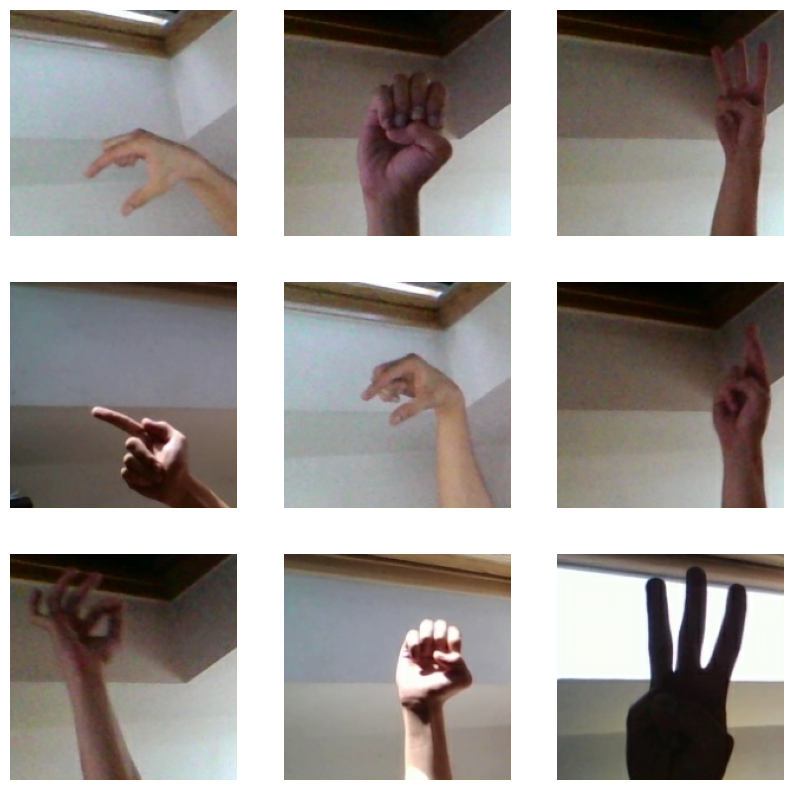

In [123]:
#Mostramos imagen de entrenamiento normalizada sin modificaciones
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  #images contiene un batch(32) de imagenes de 56x56x3
  #labels contiene un array de 32 arrays con 10 clases marcando un 1 o 0 dependiendo de la clase de cada imagen
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy()) ## usar .astype("uint8") si las imagenes van de 0 a 255 si no float 0 a 1
    #plt.title(class_names[labels[i].numpy().tolist().index(1)-2])
    plt.axis("off")

In [150]:
# class myRandomShear(Layer):

#   def __init__(self, name=None, **kwargs):
#     super(myRandomShear, self).__init__(name=name, **kwargs)

#   def call(self, inputs):
#     array_inputs = tf.keras.preprocessing.image.img_to_array(inputs)
#     return tf.keras.preprocessing.image.random_shear(array_inputs, 30, row_axis=0, col_axis=1, channel_axis=2)

#   def compute_output_shape(self, input_shape):
#     return input_shape

#   def get_config(self):
#     base_config = super(myRandomShear, self).get_config()
#     return dict(list(base_config.items()))

#Configuramos nuestra capa de data augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        #tf.keras.layers.RandomRotation(0.1),
        #tf.keras.layers.RandomShear(0.3),
        tf.keras.layers.RandomZoom(0.05),
        tf.keras.layers.RandomTranslation(0.05, 0.05),
        tf.keras.layers.RandomBrightness([-0.1,0.2],value_range=(0, 1)),
        #myRandomShear()
        #tf.keras.layers.RandomCrop(25,25),
        #tf.keras.layers.RandomContrast(0.3)
    ]
)
data_augmentation.build((None, image_side, image_side, 3)) ## this is important to prevent usage of data augmentation change his shape

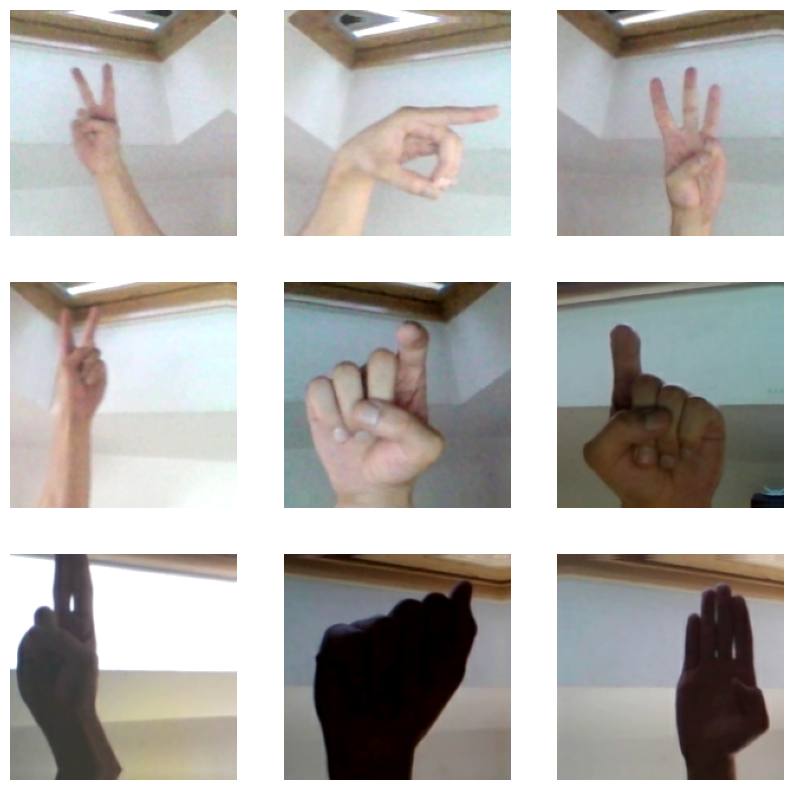

In [175]:
#probamos nuestro data augmentation
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  #images contiene un batch(32) de imagenes de 56x56x3
  #labels contiene un array de 32 arrays con 10 clases marcando un 1 o 0 dependiendo de la clase de cada imagen
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data_augmentation(images[i].numpy())) ## usar .astype("uint8") si las imagenes van de 0 a 255 si no float 0 a 1
    #plt.title(class_names[labels[i].numpy().tolist().index(1)-2])
    plt.axis("off")

In [176]:
# VGG19
# Importamos el modelo base que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(image_side,image_side,3),
                                          include_top=False,
                                          weights='imagenet')

#resNet = tf.keras.applications.ResNet50(input_shape=(image_side,image_side,3),
#                                          include_top=False,
#                                          weights='imagenet')

#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[:6]:
  layer.trainable = False


# Creamos un nuevo modelo
model = tf.keras.Sequential([

##original, val_loss aumenta
  data_augmentation,
  VGG19_model,
  
#  data_augmentation,
#  resNet,

##base
  Flatten(),
  Dropout(0.25),
  Dense(64, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'),
  Dropout(0.25),
  Dense(len(class_names), activation = 'softmax')
])

model.build((None, image_side, image_side, 3))
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_26 (Sequential)  (None, 192, 192, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 6, 6, 512)         20024384  
                                                                 
 flatten_5 (Flatten)         (None, 18432)             0         
                                                                 
 dropout_10 (Dropout)        (None, 18432)             0         
                                                                 
 dense_10 (Dense)            (None, 64)                1179712   
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 24)              

In [179]:
## EJECUCION DEL MODELO
model.compile(loss="categorical_crossentropy",
              optimizer= SGD(learning_rate=0.01),
              metrics=['accuracy'])

#Agregamos un callback para guardar checkpoints y modificar el learning rate dinamicamente
checkpointer = ModelCheckpoint(filepath='model', verbose=1, save_best_only=True, monitor = 'val_accuracy', mode = 'max')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                              patience=3, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_ds,validation_data = validation_ds,
                             callbacks = [
#                                 reduce_lr,
                                    checkpointer
#                                 early_stop
                                ],
                   epochs=epochs)

Epoch 1/15
1125/1125 [==============================] - ETA: 0s - loss: 1.8587 - accuracy: 0.7552
Epoch 1: val_accuracy improved from -inf to 0.65694, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1125/1125 [==============================] - 141s 124ms/step - loss: 1.8587 - accuracy: 0.7552 - val_loss: 2.7967 - val_accuracy: 0.6569
Epoch 2/15
1125/1125 [==============================] - ETA: 0s - loss: 0.7129 - accuracy: 0.9920
Epoch 2: val_accuracy improved from 0.65694 to 0.67361, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1125/1125 [==============================] - 141s 125ms/step - loss: 0.7129 - accuracy: 0.9920 - val_loss: 2.1497 - val_accuracy: 0.6736
Epoch 3/15
1125/1125 [==============================] - ETA: 0s - loss: 0.4558 - accuracy: 0.9964
Epoch 3: val_accuracy did not improve from 0.67361
1125/1125 [==============================] - 139s 123ms/step - loss: 0.4558 - accuracy: 0.9964 - val_loss: 2.4769 - val_accuracy: 0.6542
Epoch 4/15
1125/1125 [==============================] - ETA: 0s - loss: 0.3166 - accuracy: 0.9928
Epoch 4: val_accuracy improved from 0.67361 to 0.67500, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1125/1125 [==============================] - 141s 125ms/step - loss: 0.3166 - accuracy: 0.9928 - val_loss: 2.0860 - val_accuracy: 0.6750
Epoch 5/15
1125/1125 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.9977
Epoch 5: val_accuracy did not improve from 0.67500
1125/1125 [==============================] - 139s 123ms/step - loss: 0.1984 - accuracy: 0.9977 - val_loss: 2.4331 - val_accuracy: 0.6542
Epoch 6/15
1125/1125 [==============================] - ETA: 0s - loss: 0.1365 - accuracy: 0.9977
Epoch 6: val_accuracy improved from 0.67500 to 0.68194, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1125/1125 [==============================] - 141s 125ms/step - loss: 0.1365 - accuracy: 0.9977 - val_loss: 1.9420 - val_accuracy: 0.6819
Epoch 7/15
1125/1125 [==============================] - ETA: 0s - loss: 0.0936 - accuracy: 0.9983
Epoch 7: val_accuracy did not improve from 0.68194
1125/1125 [==============================] - 140s 124ms/step - loss: 0.0936 - accuracy: 0.9983 - val_loss: 2.5530 - val_accuracy: 0.6611
Epoch 8/15
1125/1125 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.9988
Epoch 8: val_accuracy did not improve from 0.68194
1125/1125 [==============================] - 140s 124ms/step - loss: 0.0631 - accuracy: 0.9988 - val_loss: 1.8164 - val_accuracy: 0.6500
Epoch 9/15
 729/1125 [==================>...........] - ETA: 48s - loss: 0.0499 - accuracy: 0.9986

KeyboardInterrupt: 

In [186]:
# the tunner
initial_dropout = 0.25
initial_image_side = 64
initial_l2 = 0.01
initial_batch_size = 32

incremental_dropout = 0.05
incremental_image_side = 32
incremental_l2 = 0.01
incremental_batch_size = 32

max_dropout = 0.5
max_image_side = 192
max_l2 = 0.05
max_batch_size = 128

number_of_training_per_test = 1 # number of times that configuration will be trained to see high accuracy that can be achieved

number_of_tests = max_dropout-initial_dropout/incremental_dropout + max_image_side-initial_image_side/incremental_image_side + max_l2-initial_l2/incremental_l2 + max_batch_size-initial_batch_size/incremental_batch_size

print("number of tests: ", number_of_tests)
print("aprox time of execution: ", number_of_tests*number_of_training_per_test*epochs*1.3, " minutes")


## Todo implement the tunning automation



number of tests:  311.55
aprox time of execution:  6075.225  minutes


In [ ]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['val_loss','loss'])
plt.show()

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['val_accuracy','accuracy'])
plt.show()

In [ ]:
model.evaluate(validation_ds)

In [ ]:
model.save("out.h5")

In [180]:
## load model from zero
model = tf.keras.models.load_model("model")

In [181]:
model.evaluate(validation_ds)

12/12 [==============================] - 1s 62ms/step - loss: 1.9420 - accuracy: 0.6819


[1.9419552087783813, 0.6819444298744202]

In [182]:
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np


## generamos predicciones

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

# convertimos el array en el que necesita sklearn
final_correct_labels = []
for lb in correct_labels:
  itlist=list(lb.numpy())
  final_correct_labels.append(itlist.index(1.0))

1/1 [==============================] - 0s 93ms/step


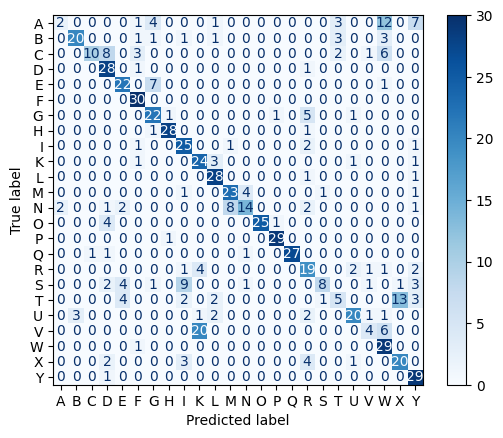

In [183]:
ConfusionMatrixDisplay.from_predictions(final_correct_labels, predicted_labels, display_labels=class_names, cmap=plt.cm.Blues)